<a href="https://colab.research.google.com/github/square-1111/Natural-Language-Generation/blob/master/Experiment2/LanguageGen_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import imdb

from keras.preprocessing.sequence import pad_sequences
from keras.utils import normalize

from keras.optimizers import RMSprop,SGD, Adam
from keras import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, multiply
from keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from keras.layers import Input, Flatten, Embedding, Reshape, Lambda
from keras.models import load_model
from keras.utils import print_summary
import keras.backend as K

from IPython import display

import tensorflow as tf

import string

Using TensorFlow backend.


In [0]:
!pip uninstall numpy -y
!pip install --upgrade numpy==1.16.2

import numpy as np

Uninstalling numpy-1.16.2:
  Successfully uninstalled numpy-1.16.2
  Using cached https://files.pythonhosted.org/packages/35/d5/4f8410ac303e690144f0a0603c4b8fd3b986feb2749c435f7cdbb288f17e/numpy-1.16.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
np.__version__

'1.16.2'

## Get GloVe

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-06-15 06:40:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-15 06:40:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-15 06:40:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
f = open("glove.6B.100d.txt", "r")
em_index = dict()
for line in f:
  values = line.split()
  word = values[0]
  embedding = np.asarray(values[1:],dtype=np.float32)
  em_index[word] = embedding

In [0]:
inv_map = {tuple(v): k for k, v in em_index.items()}

In [0]:
all_embeddings = np.array(list(em_index.values()))

In [0]:
lowest = np.amin(all_embeddings, axis=0)

In [0]:
highest = np.amax(all_embeddings,axis=0)

In [0]:
def normalize(embedding):
  return (embedding - lowest)/(highest-lowest)

## Get IMDB dataset

In [0]:
max_features = 100000
(x_train, y_train), (x_test,y_test) = imdb.load_data(num_words=max_features)

In [0]:
data = [example for example in x_train if (len(example)<200 and len(example)>60)]
data.extend([example for example in x_test if (len(example)<200 and len(example)>60)])

len(data)


26827

In [0]:
data_to_lstm = pad_sequences(data, maxlen=200)
type(data_to_lstm)

numpy.ndarray

### Indices to Word

In [0]:
word_to_index = imdb.get_word_index()
for (k,v) in word_to_index.items():
  word_to_index[k] = v + 3

index_to_word = {}
index_to_word[0] = "PAD"
index_to_word[1] = "START"
index_to_word[2] = "OOV"
for (k,v) in word_to_index.items():
  index_to_word[v] = k

### Generate Sentences

In [0]:
sentences = []
for example in data:
  sent = ' '.join([index_to_word.get(num,'?') for num in example])
  sentences.append(sent[6:])

sentences[:10]

["big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their stomachs sickening that men actually wore them and the music is just synthesiser trash that plays over and over again in almost every scene there is trashy music boobs and paramedics taking away bodies and the gym still doesn't close for bereavement all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then",
 "this

## Generate 2D Embeddings

In [0]:
def removePunct(sent):
  return sent.translate(str.maketrans('', '', string.punctuation))

In [0]:
def gen_2DEmbedding(sentence, max_len):
  embedding2D = [] 
  sent = removePunct(sentence)
  sent = sent.replace("  "," ")
  words = sent.split(" ")
  
  for word in words:
    if word in em_index:
      embedding2D.append(normalize(em_index[word]))
    else:
      embedding2D.append([0.5]*100)
  
  rem = max_len - len(words)
  for _ in range(rem):
    a = [0.5]*100
    embedding2D.append(a)
  
  embedding2D = np.array([np.array(xi) for xi in embedding2D])
  return embedding2D
  

In [0]:
max_len = 200
embed_sentences = [gen_2DEmbedding(sent,max_len) for sent in sentences]

In [0]:
embed_sentences = np.array(embed_sentences)

In [0]:
embed_sentences = np.reshape(embed_sentences,
                             (embed_sentences.shape[0],embed_sentences.shape[1],embed_sentences.shape[2],1))

### Plot the dataset (2D embeddings)

In [0]:
import matplotlib.pyplot as plt

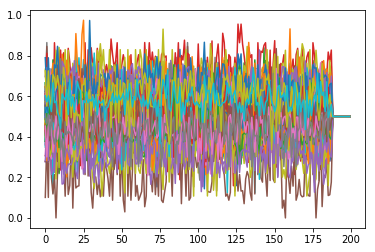

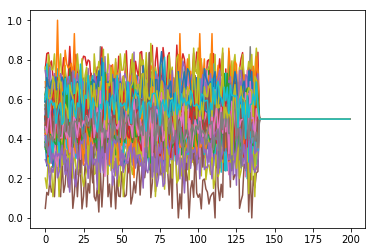

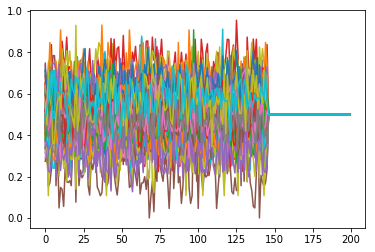

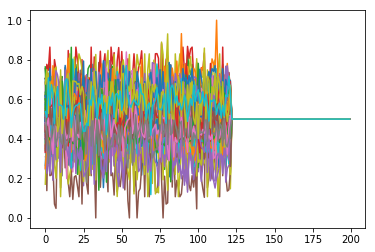

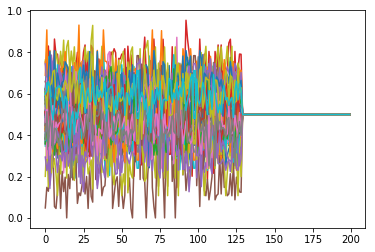

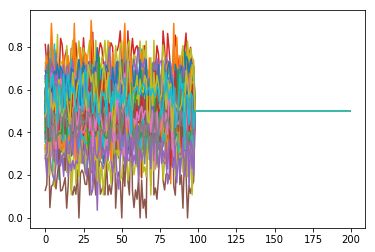

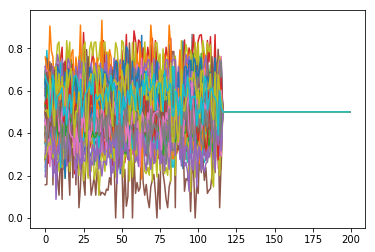

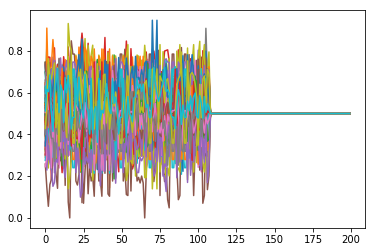

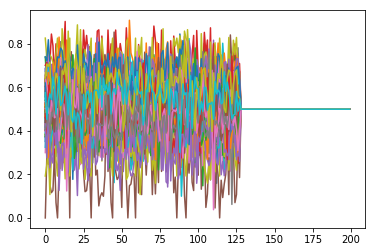

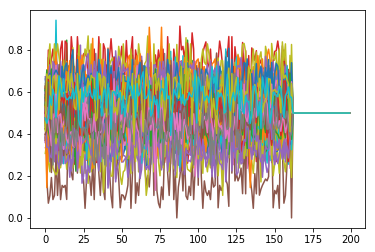

In [0]:
for i in range(10):
  mat = gen_2DEmbedding(sentences[i],200)
  fig = plt.figure()
  plt.plot(mat)
  plt.show()

## GAN

### Basic Preprocessing

In [0]:
img_rows, img_cols, channels = 200, 100, 1
img_shape = (img_rows, img_cols, channels)

latent_dim = 100

batch_size = 32

optimizer_g = Adam(lr=0.00005)
optimizer_d = SGD(lr=0.01)

### Get model to extract features of sentence for Conditioning GAN

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = 'gdrive/My Drive/SentFeatures.h5'
sent_fea_model = load_model(path)

W0615 06:41:44.945486 140274777487232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 06:41:44.950551 140274777487232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 06:41:44.955128 140274777487232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 06:41:45.191655 140274777487232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0615 06:41:45.192632 1402747774

In [0]:
sent_fea_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1_input (InputLaye (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 32)           3200000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
Total params: 3,253,200
Trainable params: 3,253,200
Non-trainable params: 0
_________________________________________________________________


In [0]:
feature_shape = 100

### Wasserstein Distance

In [0]:
def wasserstein_loss(y_true, y_pred):
  return K.mean(y_true * y_pred)

### Discriminator

In [0]:
def disc():
  discriminator = Sequential()
  discriminator.add(Conv2D(512, kernel_size=(3,100), input_shape=img_shape))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Flatten())
  
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Dropout(rate=0.6))

  discriminator.add(Dense(64))
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Dropout(rate=0.6))

  discriminator.add(Dense(1, activation='sigmoid'))
  
  img_inp = Input(shape=(img_shape[0],img_shape[1],img_shape[2],))
  feature = Input(shape=(feature_shape,))
  
  feature_reshaped_100_1 = Lambda(lambda x: tf.expand_dims(x,-1))(feature)
  feature_reshaped_20000_1 = Lambda(lambda x: K.repeat_elements(x,200, axis=1))(feature_reshaped_100_1)
  feature_reshaped = Reshape((200,100,1))(feature_reshaped_20000_1)
  
  print(feature_reshaped_20000_1)
  print(feature_reshaped)
  
#   print(feature_reshaped)
  dis_input = Lambda(lambda x: tf.multiply(x[0], x[1]))([img_inp, feature_reshaped])
#   print(dis_input)
  
  validity = discriminator(dis_input)
  
  return Model([img_inp, feature],validity)

In [0]:
discriminator = disc()
discriminator.summary()


W0615 06:41:46.057084 140274777487232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0615 06:41:46.058552 140274777487232 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0615 06:41:46.090083 140274777487232 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0615 06:41:48.189420 140274777487232 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0615 06:41:48.211149 140274777487232 nn_op

Tensor("lambda_2/concat:0", shape=(?, 20000, 1), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 200, 100, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 20000, 1)     0           lambda_1[0][0]                   
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 200, 100, 1)  0                     

In [0]:
discriminator.compile(loss=wasserstein_loss,optimizer=optimizer_d,
                      metrics=['accuracy'])

W0615 06:41:48.239837 140274777487232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Generator

In [0]:
def gen():
  generator = Sequential()

  generator.add(Dense(batch_size*np.prod(img_shape), input_dim=latent_dim))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Reshape((200,100, batch_size)))
  
  generator.add(Conv2D(256, 5, padding='same'))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Conv2D(256, 5, padding='same'))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Conv2D(256, 5, padding='same'))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Conv2D(256, 5, padding='same'))
  generator.add(LeakyReLU(0.2))
  
  generator.add(Conv2D(channels, 7, activation='sigmoid', padding='same'))
  
  noise = Input(shape=(latent_dim,))
  feature = Input(shape=(feature_shape,))
  
  gen_input = Lambda(lambda x: tf.multiply(x[0], x[1]))([noise, feature])

  gen_img = generator(gen_input)
  
  return Model([noise,feature], gen_img)

In [0]:
generator = gen()
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 100)          0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 200, 100, 1)  69773569    lambda_4[0][0]                   
Total para

### Generator and Discriminator combined

In [0]:
noise = Input(shape=(latent_dim,))
feature = Input(shape=(feature_shape,))
gen_img = generator([noise, feature])

In [0]:
valid = discriminator([gen_img, feature])

W0615 06:41:50.226220 140274777487232 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
discriminator.trainable = False

gan = Model([noise, feature], valid)
gan.compile(loss=wasserstein_loss,optimizer=optimizer_g)
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 200, 100, 1)  69773569    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            26123137    model_2[1][0]                    
          

### Draw Loss

In [0]:
def plot_loss(losses):
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.figure(figsize=(10,8))
  plt.plot(losses["d"], label='discriminitive loss')
  plt.plot(losses["g"], label='generative loss')
  plt.legend()
  plt.show()

### Train GAN

In [0]:
def convToEmbed(sent):
  sent = sent.lower()
  sent = removePunct(sent)
  words = sent.split(' ')
  arr = [word_to_index.get(word) for word in words]
  arr = np.asarray(arr)
  paded = pad_sequences([arr],maxlen=200)
  return paded

In [0]:
epochs = 200
num_d, num_g = 5, 1
num_examples = 26827

losses = {"d":[], "g":[]}

In [0]:
valid = np.ones((batch_size,1))
fake = np.zeros((batch_size,1))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

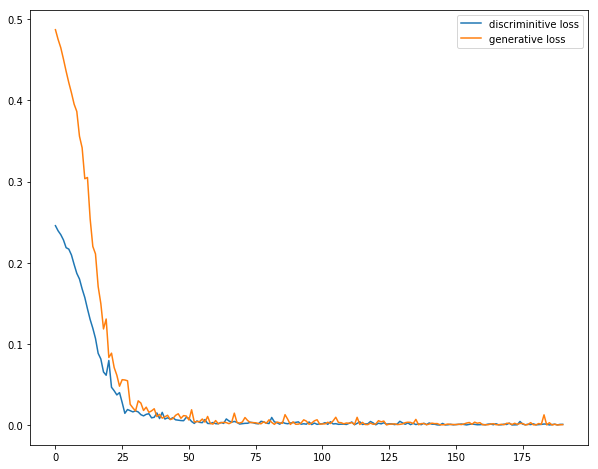

Iteration = 190 ---------------------
GAN loss = 0.0006113089621067047
Discriminator loss 0.0009324322454631329


In [0]:
for step in range(epochs):
  for _ in range(num_d):
    idx = np.random.randint(0, num_examples, batch_size)

    embed_sent = data_to_lstm[idx]
    feature_sente_s = sent_fea_model.predict(embed_sent)
    real_2d_embed = embed_sentences[idx]

    noise = np.random.normal(0,1,(batch_size, 100))

    gen_2d_embed = generator.predict([noise,feature_sente_s])

    d_loss_real = discriminator.train_on_batch([real_2d_embed, feature_sente_s],valid)
    d_loss_fake = discriminator.train_on_batch([gen_2d_embed,feature_sente_s],fake)
    d_loss = 0.5*np.add(d_loss_fake,d_loss_real)
  
  losses["d"].append(d_loss[0])
  
  for __ in range(num_g):
    sampled_features_idx = np.random.randint(0, num_examples, batch_size)
    sampled_embed_sent = data_to_lstm[sampled_features_idx]
    sampled_features = sent_fea_model.predict(sampled_embed_sent)

    g_loss = gan.train_on_batch([noise, sampled_features],valid)
  
  losses["g"].append(g_loss)
  
  if step%10 == 0:
    plot_loss(losses)
    print("Iteration = {} ---------------------".format(step))
    print("GAN loss = {}".format(g_loss))
    print("Discriminator loss {}".format(d_loss[0]))


## Post Processing


In [0]:
def convToSentEmbed(sent):
  sent = sent.lower()
  sent = removePunct(sent)
  words = sent.split(' ')
  arr = [word_to_index.get(word) for word in words]
  arr = np.asarray(arr)
  paded = pad_sequences([arr],maxlen=200)
  return paded

In [0]:
def denormalise(embedding):
  return embedding*(highest-lowest) + lowest

In [0]:
def l2norm(emb_ori, emb_new):
  dist = np.linalg.norm(np.array(emb_ori)-np.array(emb_new))
  return dist

In [0]:
def getmin(embed):
  embed = tuple(embed)
  emb_ori = em_index['the']
  mini = l2norm(emb_ori, embed)
  word = 'the'
  
  for key, value in em_index.items():
    dist = l2norm(value, embed)
    if dist < mini:
      word = key
      mini = dist
  
  return word

In [0]:
def difference_k_mini(embed, k):
  diff_embed = np.sum(np.square(all_embeddings - embed),axis=0)
  idx = np.argpartition(diff_embed, k)
  word_embed_min_k = all_embeddings[idx[:k]]
  
  return word_embed_min_k
  

In [0]:
def decode(mat):
  sss = []
  count = 0
  for emb in mat:
    word = getmin(emb)
    sss.append(word)
    count = count + 1
    print(count)
    print(word)
  sent = ' '.join(sss)
  return sss

In [0]:
def getword(difference_list):
  words = []
  for embed in difference_list:
    words.append(inv_map.get(tuple(embed)))
    
  return words
  

In [0]:
def deco(mat):
  count = 0 
  k = 5
  for emb in mat:
    k_embed = difference_k_mini(emb,5)
    print("{} : {}".format(count, getword(k_embed)))
    count = count + 1

In [0]:
gen_blue

array([[2.0520048, 2.418638 , 2.621739 , ..., 2.551916 , 2.3033059,
        2.474854 ],
       [2.3031006, 2.495004 , 2.6494832, ..., 2.5779226, 2.3663213,
        2.643763 ],
       [2.392096 , 2.5126088, 2.653788 , ..., 2.582328 , 2.3828914,
        2.7100248],
       ...,
       [2.3878312, 2.5116284, 2.6534548, ..., 2.5817358, 2.3797638,
        2.6907659],
       [2.2935715, 2.4905832, 2.647294 , ..., 2.5744216, 2.3542287,
        2.5924406],
       [2.0437217, 2.406555 , 2.6105556, ..., 2.5337303, 2.2619164,
        2.35788  ]], dtype=float32)

In [0]:
alpha_w = deco(gen_blue)

0 : ['two', 'the', 'after', 'will', 'been']
1 : ['after', 'two', 'they', 'will', 'been']
2 : ['will', 'two', 'after', 'been', 'they']
3 : ['will', 'two', 'after', 'been', 'they']
4 : ['will', 'two', 'after', 'been', 'they']
5 : ['will', 'two', 'after', 'been', 'they']
6 : ['will', 'two', 'after', 'been', 'they']
7 : ['will', 'two', 'after', 'been', 'they']
8 : ['will', 'two', 'after', 'been', 'they']
9 : ['will', 'two', 'after', 'been', 'they']
10 : ['will', 'two', 'after', 'been', 'they']
11 : ['will', 'two', 'after', 'been', 'they']
12 : ['will', 'two', 'after', 'been', 'they']
13 : ['will', 'two', 'after', 'been', 'they']
14 : ['will', 'two', 'after', 'been', 'they']
15 : ['will', 'two', 'after', 'been', 'they']
16 : ['will', 'two', 'after', 'been', 'they']
17 : ['will', 'two', 'after', 'been', 'they']
18 : ['will', 'two', 'after', 'been', 'they']
19 : ['will', 'two', 'after', 'been', 'they']
20 : ['will', 'two', 'after', 'been', 'they']
21 : ['will', 'two', 'after', 'been', 'they']

In [0]:
review =   "i love cheesy horror flicks i don't care if the acting is sub par or whether the monsters look corny i liked this movie except for the bewildered feeling all the way from the beginning of the film to the very end look i don't need a 10 page dissertation or a sign with big letters explaining a plot to me but dark floors takes the what is this movie about thing to a whole new annoying level what is this movie about br br this isn't exceptionally scary or thrilling but if you have an hour and a half to kill and or you want to end up feeling frustrated and confused rent this winner"

In [0]:
test_sent = convToEmbed(review)

In [0]:
test_sent_features = sent_fea_model.predict(test_sent)

In [0]:
noise_test = np.random.normal(0,1,(1, 100))

In [0]:
test_gen_3dembed = generator.predict([noise_test, test_sent_features])[0]

In [0]:
test_gen_3dembed.shape

(200, 100, 1)

In [0]:
test_gen_2dembed = np.reshape(test_gen_3dembed,(200,100))

In [0]:
test_gen_2dembed_list = [denormalise(embedding) for embedding in test_gen_2dembed]

In [0]:
test_sent = deco(test_gen_2dembed_list)

0 : ['two', 'the', 'after', 'will', 'been']
1 : ['after', 'two', 'they', 'will', 'been']
2 : ['will', 'two', 'after', 'been', 'they']
3 : ['will', 'two', 'after', 'been', 'they']
4 : ['will', 'two', 'after', 'been', 'they']
5 : ['will', 'two', 'after', 'been', 'they']
6 : ['will', 'two', 'after', 'been', 'they']
7 : ['will', 'two', 'after', 'been', 'they']
8 : ['will', 'two', 'after', 'been', 'they']
9 : ['will', 'two', 'after', 'been', 'they']
10 : ['will', 'two', 'after', 'been', 'they']
11 : ['will', 'two', 'after', 'been', 'they']
12 : ['will', 'two', 'after', 'been', 'they']
13 : ['will', 'two', 'after', 'been', 'they']
14 : ['will', 'two', 'after', 'been', 'they']
15 : ['will', 'two', 'after', 'been', 'they']
16 : ['will', 'two', 'after', 'been', 'they']
17 : ['will', 'two', 'after', 'been', 'they']
18 : ['will', 'two', 'after', 'been', 'they']
19 : ['will', 'two', 'after', 'been', 'they']
20 : ['will', 'two', 'after', 'been', 'they']
21 : ['will', 'two', 'after', 'been', 'they']

In [0]:
omega = decode(test_gen_2dembed_list)

1
asphalt
2
asphalt
3
asphalt
4
asphalt
5
asphalt
6
asphalt
7
asphalt
8
asphalt
9
asphalt
10
asphalt
11
asphalt
12
asphalt
13
asphalt
14
asphalt
15
asphalt
16
asphalt
17
asphalt
18
asphalt
19
asphalt
20
asphalt
21
asphalt
22
asphalt
23
asphalt
24
asphalt
25
asphalt
26
asphalt
27
asphalt
28
asphalt
29
asphalt
30
asphalt
31
asphalt
32
asphalt
33
asphalt
34
asphalt
35
asphalt
36
asphalt
37
asphalt
38
asphalt
39
asphalt
40
asphalt
41
asphalt
42
asphalt
43
asphalt
44
asphalt
45
asphalt
46
asphalt
47
asphalt
48
asphalt
49
asphalt
50
asphalt
51
asphalt
52
asphalt
53
asphalt
54
asphalt
55
asphalt
56
asphalt
57
asphalt
58
asphalt
59
asphalt
60
asphalt
61
asphalt
62
asphalt
63
asphalt
64
asphalt
65
asphalt
66
asphalt
67
asphalt
68
asphalt
69
asphalt
70
asphalt
71
asphalt
72
asphalt
73
asphalt
74
asphalt
75
asphalt
76
asphalt
77
asphalt
78
asphalt
79
asphalt
80
asphalt
81
asphalt
82
asphalt
83
asphalt
84
asphalt
85
asphalt
86
asphalt
87
asphalt
88
asphalt
89
asphalt
90
asphalt
91
asphalt
92
aspha

In [0]:
' '.join(omega)

'asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt asphalt